In [28]:
from flask import Flask
from flask import request
import datetime
from dateutil.parser import parse
import json
import numpy as np
import random 
import collections
import copy 
import math
from operator import itemgetter
import plotly.figure_factory as ff
from itertools import groupby
import pandas as pd

In [29]:
info_pr = {'process_info': [[[[1, 1, 10], [2, 1, 11]], [[3, 1, 12]], [[2, 1, 13]]],
                            [[[3,1,14], [1,1,15], [2,1,16]], [[2,1,17], [3,1,18]], [[3,1,19]]],
                            [[[1,1,1],[2,1,2]]]],
           "job_nb": 3, 'total_op_nb': 7, 'machine_nb': 3,'machine_list':[1,2,3], 'machine_aval':[0,0,0],
           'periodStartDate':"2022-11-01 00:00:00",
           'job_dict':{1:['order 1', 1], 2:['order 2', 1],3:['order 3', 1]},
           'machine_dict':{1:'machine 1',2:'machine 2',3:'machine 3'}
           }

app = Flask(__name__)


In [3]:
required_data ={
	"rest": [
		[
			"11:00:00",
			"12:00:00"
		],
		[
			"17:00:00",
			"18:00:00"
		],
		[
			"23:00:00",
			"06:00:00"
		]
	],
	"hours": 22,
	"process": {
		"2282e0115a69df078c8dee5e40530441": [{
				"machinePriority": [
					10
				],
				"isInspection": False,
				"processTime": [
					20
				],
				"fixture": [
					"cedbb4066ef858f5f9e44330d0dbe948"
				],
				"machine": [
					"54d8e2a76e003c5a0f9e8d512d0ff4be"
				]
			},
			{
				"machinePriority": [
					10
				],
				"isInspection": False,
				"processTime": [
					25
				],
				"fixture": [
					"cedbb4066ef858f5f9e44330d0dbe948"
				],
				"machine": [
					"d86e56378c944b8aa50a6585d1af61c4"
				]
			},
			{
				"machinePriority": [
					10
				],
				"isInspection": False,
				"processTime": [
					30
				],
				"fixture": [
					"cedbb4066ef858f5f9e44330d0dbe948"
				],
				"machine": [
					"d86e56378c944b8aa50a6585d1af61c4"
				]
			}
		]
	},
	"fixtures": [
		"089701f6a423595d99d1140c6f19ab0d",
		"3089460e265c81f2f9fb0717a092f445",
		"6e584cf59219b955fe7e10d4bb32aa42",
		"6f0011f3691041cb611306c93bc45296",
		"7784578e9a8d684800a730af493ca5fd",
		"a6b27f26aa9e502ece33fa55fd908612",
		"afc7f708a16da1a8e9314a0019908e14",
		"c29d2bf2bf7a914ab08ceaac5f08b977",
		"cedbb4066ef858f5f9e44330d0dbe948"
	],
	"shiftTime": [
		"08:00:00",
		"19:00:00",
		"20:00:00",
		"07:00:00"
	],
	"machineAval": [
		10,100
	],
	"machineNotAvalPeriod": {
		"54d8e2a76e003c5a0f9e8d512d0ff4be": [
			[
				"2022-10-17 19:00:00",
				"2022-10-18 07:00:00"
			],
			[
				"2022-10-18 19:00:00",
				"2022-10-19 07:00:00"
			]
		],
		"d86e56378c944b8aa50a6585d1af61c4": [
			[
				"2022-10-21 14:00:00",
				"2022-10-21 18:00:00"
			]
		],
  
	},
	"periodLength": 7,
	"periodStartDate": "2022-10-01 00:00:00",
	"orders": [{
		"productID": "2282e0115a69df078c8dee5e40530441",
		"orderID": "3d5b33e804ead1005718c52d9a5f1a32",
		"dateEnd": "2022-10-07",
		"productNB": 60,
		"dateBegin": "2022-10-01",
		"orderLevel": 1
	}],
	"machines": [
		"54d8e2a76e003c5a0f9e8d512d0ff4be",
		"d86e56378c944b8aa50a6585d1af61c4"
	],
	"staff": [
		"staff1",
		"staff2",
		"staff3",
		"staff4",
        "staff5",
        "staff6"
        
	],
	"fixtureNB": [
		1,
		109,
		1,
		10,
		1,
		10,
		1,
		10,
		1
	],
	"cooperatedMachine": [
		[
			"54d8e2a76e003c5a0f9e8d512d0ff4be",
			"d86e56378c944b8aa50a6585d1af61c4"
		]
	],
	"nonProcessingTime": 10,
	"staffCapacity": {
		"54d8e2a76e003c5a0f9e8d512d0ff4be": [
			[
				"staff1",
				"staff2"
			],
			[
				3,
				4
			]
		],
		"d86e56378c944b8aa50a6585d1af61c4": [
			[
				"staff1",
				"staff2",
				"staff3",
				"staff4"
			],
			[
				1,
				2,
				3,
				4
			]
		]
	}
}

In [45]:
required_data = {
    "periodStartDate": "2022-11-01 08:00:00", ##! 当前排产周期的开始时间
    "shiftTime": ["08:00", "19:00", "20:00", "07:00"], ##! 白班、夜班的开始和结束时间
    "orders": [ ##! 当前排产周期订单信息
        {   
            'orderID': '001',
            'productID': '0213配油盘',
            'productNB': 1
        },
        {
            'orderID': '002',
            'productID': '12M26机体',
            'productNB': 1
        },
        {
            'orderID': '003',
            'productID': 'PSI机体',
            'productNB': 1
        }
    ],
    "process": { ##! 产品加工工艺信息
        '0213配油盘': [
            {
                'machine': ['MC6000-7'],
                'processTime': [20],
                'fixture': ['F1'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-7'],
                'processTime': [35],
                'fixture': ['F1'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-7'],
                'processTime': [30],
                'fixture': ['F2'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-7'],
                'processTime': [30],
                'fixture': ['F2'],
                'isInspection': False
            }
        ],
        '12M26机体': [
            {
                'machine': ['MC6000-6'],
                'processTime': [50],
                'fixture': ['F3'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-7'],
                'processTime': [75],
                'fixture': ['F4'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-6'],
                'processTime': [60],
                'fixture': ['F4'],
                'isInspection': False
            },
            {
                'machine': ['MC6000-6'],
                'processTime': [30],
                'fixture': ['F5'],
                'isInspection': True
            }
        ],
        'PSI机体': [
            {
                'machine': ['德玛吉五轴', '乌尼恩-1#'],
                'processTime': [276, 276],
                'fixture': ['F6', 'F7'],
                'isInspection': False
            },
            {
                'machine': ['德玛吉五轴', '英赛-1#'],
                'processTime': [360, 360],
                'fixture': ['F8', 'F9'],
                'isInspection': False
            },
            {
                'machine': ['德玛吉五轴', '英赛-1#', 'BW'],
                'processTime': [276, 276, 300],
                'fixture': ['F10', 'F11', 'F12'],
                'isInspection': False
            },
            {
                'machine': ['南MTM清洗机'],
                'processTime': [252],
                'fixture': [],
                'isInspection': False
            }
        ]
    },
    "machines": ['MC6000-6', 'MC6000-7', '德玛吉五轴', '乌尼恩-1#', '英赛-1#', 'BW', '南MTM清洗机', '北MTM清洗机'], ##! 当前排产周期的设备列表 可以是所有设备，即便没有用到
    "cooperatedMachine": [['MC6000-6', 'MC6000-7'], ['德玛吉五轴', '乌尼恩-1#'], ['英赛-1#', 'BW'], ['南MTM清洗机']], ##! 当前排产周期的设备协同关系 也可以是所有设备，但用到的必须要有
    "staff": ['张成龙','崔焕友','刘宝强','臧志远','张晓辉','冯金明'], ##! 当前排产周期的员工列表，也可以是所有
    "staffCapacity": {
        'MC6000-6': [['崔焕友','刘宝强','张成龙'],[4,4,6]],
        'MC6000-7': [['崔焕友','刘宝强','张成龙'],[4,4,6]],
        '德玛吉五轴': [['张成龙','臧志远','张晓辉','冯金明'],[6,4,4,8]],
        '乌尼恩-1#': [['张成龙','臧志远','张晓辉','冯金明'],[6,4,4,8]],
        '英赛-1#': [['张成龙','臧志远','张晓辉','冯金明'],[6,4,4,8]],
        'BW':[['张成龙','臧志远','张晓辉','冯金明'],[6,4,4,8]],
        '南MTM清洗机': [['张成龙','张晓辉','冯金明'],[6,4,8]]}, ##! 当前排产周期的员工能力， 也可以是所有
    "machineAval": [0, 0, 0, 0, 0, 0, 0], ##! 当前排产周期的设备可用时间
    "machineNotAvalPeriod": { ##! 当前排产周期的设备不可用时间段 要和"machines"对应
        'MC6000-6': [['2022-11-01 01:00:00', '2022-11-01 08:00:00'], ['2022-11-01 19:00:00', '2022-11-02 08:00:00']], ##! 夜班不可用
        'MC6000-7': [],#[['2022-11-01 19:00:00', '2022-11-02 08:00:00'], ['2022-11-02 19:00:00', '2022-11-03 08:00:00']],
        '德玛吉五轴': [],
        '乌尼恩-1#': [],
        '英赛-1#': [],
        'BW': [],
        '南MTM清洗机': [['2022-11-01 12:00:00', '2022-11-01 18:00:00']],##! 维修时间
        '北MTM清洗机': []
    },
    "nonProcessingTime": 15, ##! 上下料、换夹具等非加工时间
}

In [46]:
def time_transform(start_time: str, period: list): 
    start_time = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    target = []
    if bool(period):
        for i in period:
            date1 = parse(i[0])
            date2 = parse(i[1])
            result1 = date1 - start_time
            result2 = date2 - start_time
            target.append([int(result1.total_seconds()//60), int(result2.total_seconds()//60)])
    return target

In [47]:
def info_pr_with_json(data_json):
    global info_pr
    info_pr['machine_nb'] = len(data_json['machines'])
    dict_machine = {}
    info_pr['machine_dict'] = {}
    for index, machine_name in enumerate(data_json['machines']):
        dict_machine[machine_name] = index + 1
        info_pr['machine_dict'][index+1] = machine_name
    info_pr['machine_list'] = [i for i in range(1, info_pr['machine_nb'] + 1)]
    
    job_nb = 0
    for order in data_json['orders']:
        job_nb += order['productNB']
    info_pr['job_nb'] = job_nb
    info_pr['start_date'] = data_json['periodStartDate']
    info_pr['machineNotAvalPeriod'] = []
    for machine, machine_index in dict_machine.items():
        info_pr['machineNotAvalPeriod'].append(time_transform(data_json['periodStartDate'], data_json['machineNotAvalPeriod'][machine]))
    
    info_pr['process_info'] = []
    info_pr['total_op_nb'] = 0
    job_count = 1
    for order in data_json['orders']:
        for job_index_in_order in range(order['productNB']):
            info_pr['job_dict'][job_count] = [order['orderID'] , job_index_in_order + 1]
            job_count += 1
            job_info = []
            processes = data_json['process'][order['productID']]
            info_pr['total_op_nb'] += len(processes)
            for process in processes:
                process_info = []
                for index, machine in enumerate(process['machine']):
                    temp = [0,1,0]
                    # 设备index 赋值
                    temp[0] = dict_machine[machine]
                    ##! 暂时忽略夹具约束
                    if bool(process['fixture']):
                        temp[1] = process['fixture'][index]
                    # 加工时间赋值
                    temp[2] = process['processTime'][index]
                    temp.append(process['isInspection'])
                    process_info.append(temp)
                job_info.append(process_info)
            info_pr['process_info'].append(job_info)
    info_pr['machine_aval'] = data_json['machineAval']
    info_pr['nonProcessingTime'] = data_json['nonProcessingTime']
    ## Sequence 加入人员需求相关的信息
    info_pr['staff'] = data_json['staff']
    info_pr['cooperatedMachine'] = data_json['cooperatedMachine']
    info_pr['staffCapacity'] = data_json['staffCapacity']
    info_pr['shiftTime'] = data_json['shiftTime']
    return info_pr
    

In [48]:
res = info_pr_with_json(required_data)
print(res['job_nb'])
print(res['machine_dict'])
print(res['total_op_nb'])
print(res['machineNotAvalPeriod'])
res['process_info'][0][1][0][1] ##! 第一维： 共几件产品 第二维： 共几道工序 第三维： 几个可选设备 第四维： 设备index、夹具、加工时间、是否为检测工序
print(res['staffCapacity'])

3
{1: 'MC6000-6', 2: 'MC6000-7', 3: '德玛吉五轴', 4: '乌尼恩-1#', 5: '英赛-1#', 6: 'BW', 7: '南MTM清洗机', 8: '北MTM清洗机'}
12
[[[-420, 0], [660, 1440]], [], [], [], [], [], [[240, 600]], []]
{'MC6000-6': [['崔焕友', '刘宝强', '张成龙'], [4, 4, 6]], 'MC6000-7': [['崔焕友', '刘宝强', '张成龙'], [4, 4, 6]], '德玛吉五轴': [['张成龙', '臧志远', '张晓辉', '冯金明'], [6, 4, 4, 8]], '乌尼恩-1#': [['张成龙', '臧志远', '张晓辉', '冯金明'], [6, 4, 4, 8]], '英赛-1#': [['张成龙', '臧志远', '张晓辉', '冯金明'], [6, 4, 4, 8]], 'BW': [['张成龙', '臧志远', '张晓辉', '冯金明'], [6, 4, 4, 8]], '南MTM清洗机': [['张成龙', '张晓辉', '冯金明'], [6, 4, 8]]}


In [34]:
JOB = [i for i in range(1, res['job_nb'] + 1)]
OPERATION = {}
for i in JOB:
    OPERATION[i] = [i for i in range(1, 1+ len(res['process_info'][i-1]))]
MACHINE = {}
pt = {}
PT = {}
for i in JOB:
    for j in OPERATION[i]:
        MACHINE[(i,j)] = [res['process_info'][i-1][j-1][k][0] for k in range(len(res['process_info'][i-1][j-1]))]
        pt[(i,j)] = [res['process_info'][i-1][j-1][k][2] for k in range(len(res['process_info'][i-1][j-1]))]
        dic_ref = dict(zip(MACHINE[(i,j)], pt[(i,j)]))
        for k in MACHINE[(i,j)]:
            PT[(i,j,k)] = dic_ref[k]
INDEX_DIC = {}
lengh = 0
for i in JOB:
    for j in OPERATION[i]:
        INDEX_DIC[(i,j)] = lengh + OPERATION[i].index(j) + 1
    lengh += len(OPERATION[i])
    
# REVERSE_INDEX_DIC = {}
# for key, value in INDEX_DIC.items():
#     REVERSE_INDEX_DIC[value] = key

# print(JOB)
# print(OPERATION)
# print(INDEX_DIC)
# print(REVERSE_INDEX_DIC)

In [43]:
# sequece 针对三种产品分别为1、2、2共5件的case
OS = [1,1,5,2,2,1,1,2,2,5,5,4,4,3,3,4,3,3,4,5]
MA = [2,2,2,2,1,2,1,1,1,2,1,1,3,3,6,7,4,3,5,7]
nonProcessingTime = res['nonProcessingTime']

def get_OS_index(OS):
    OS_copy = OS.copy()
    OS_index = [] ##! OS中各工序对应在MA中的位置, 从1开始
    OS_index_PT = [] ##! OS中各工序对应该产品的第几道工序，PT:product
    L = len(OS)
    for i in range(L):
        count = collections.Counter(OS_copy)
        operation_index  = len(OPERATION[OS[i]]) - count[OS[i]]
        OS_index.append(INDEX_DIC[(OS[i], OPERATION[OS[i]][operation_index])])
        OS_index_PT.append(OPERATION[OS[i]][operation_index])
        OS_copy.pop(0)
    return OS_index, OS_index_PT

def find_available_gap(notAvalPeriod, pt, nonProcessingTime, last_op_end_time):
    ##! notAvalPeriod: 机器不可用时间段
    ##! pt: 工序加工时间
    ##! nonProcessingTime: 机器间隔时间
    ##! last_op_end_time: 上道工序结束时间
    ##! 返回值：可用时间段的起始时间
    possible_start_time = []
    time_list = notAvalPeriod.copy()
    time_list.sort() ##! 按时间先后排序
    time_list.insert(0, [0,0])
    for i in range(len(time_list)-1):
        gap = time_list[i+1][0] - max(time_list[i][1], last_op_end_time)
        if gap >= pt + nonProcessingTime:
            if last_op_end_time == 0:
                possible_start_time.append(time_list[i][1])
            else:
                possible_start_time.append(max(time_list[i][1], last_op_end_time + nonProcessingTime))
    if possible_start_time == []:
        if last_op_end_time == 0:
            possible_start_time.append(time_list[-1][1])
        else:
            possible_start_time.append(max(time_list[-1][1], last_op_end_time + nonProcessingTime))
    return possible_start_time

def decode(OS_chrom, MA_chrom):
    L = len(OS_chrom)
    schedule = np.zeros((2, L), dtype=int)
    machineNotAvalPeriod = res['machineNotAvalPeriod']
    updated_machineNotAvalPeriod = copy.deepcopy(machineNotAvalPeriod)
    OS_index, OS_index_PT = get_OS_index(OS_chrom)
    for i in range(L):
        current_product = OS_chrom[i]
        current_machine = MA_chrom[OS_index[i]-1] ##! 从1开始
        if OS_index_PT[i] == 1:
            last_op_end_time = 0
        else:
            last_op_end_time = schedule[1][OS_index[i]-2]
        schedule[0][OS_index[i]-1] = find_available_gap(updated_machineNotAvalPeriod[current_machine-1], \
        PT[(current_product, OS_index_PT[i], current_machine)], nonProcessingTime, last_op_end_time)[0]
        schedule[1][OS_index[i]-1] = schedule[0][OS_index[i]-1] + PT[(current_product, OS_index_PT[i], current_machine)]
        ## 更新机器不可用时间段
        updated_machineNotAvalPeriod[current_machine-1].append([schedule[0][OS_index[i]-1], schedule[1][OS_index[i]-1] + nonProcessingTime])
    return schedule

print(decode(OS, MA))

[[   0   35  175  220    0   85  175  250   65  265  355  430    0  666
  1041 1356    0  291  666  957]
 [  20   70  205  250   50  160  235  280  115  340  415  460  276 1026
  1341 1608  276  651  942 1209]]


In [44]:
def gannt():
    scheduling = decode(OS,MA)
    X_ijk = {}
    ST_ij = {}
    CT_ij = {}
    for i in JOB:
        for j in OPERATION[i]:
            for k in MACHINE[(i,j)]:
                if k == MA[INDEX_DIC[(i,j)]-1]:
                    X_ijk[(i,j,k)] = 1
                else:
                    X_ijk[(i,j,k)] = 0
    for i in JOB:
        for j in OPERATION[i]:
            ST_ij[(i,j)] = scheduling[0][INDEX_DIC[(i,j)]-1]
            CT_ij[(i,j)] = scheduling[1][INDEX_DIC[(i,j)]-1]
    index_record = []
    job_record = {}
    SolutionDict = {}
    for i in JOB:
        for j in OPERATION[i]:
            for m in MACHINE[(i,j)]:
                Keyname_X = '_(' + str(i) + ',_'+str(j) + ',_' + str(m) + ')'
                SolutionDict[Keyname_X] = [X_ijk[(i,j,m)], ST_ij[(i,j)], CT_ij[(i,j)]]
                if SolutionDict[Keyname_X][0] == 1:
                    initial_time = datetime.datetime.strptime("2022-11-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                    start_time = initial_time + datetime.timedelta(minutes=SolutionDict[Keyname_X][1].astype(np.float64))
                    end_time = initial_time + datetime.timedelta(minutes=SolutionDict[Keyname_X][2].astype(np.float64))
                    processing_time = CT_ij[(i,j)] - ST_ij[(i,j)]
                    job_record[(i,j,m)] = [start_time,end_time,processing_time]
                    index_record.append([i,j,m])
    index_record.sort(key=itemgetter(2))
    df1 = []
    colors = {}
    for i in index_record:
        df1.append(dict(Task='Machine %s' % (i[2]), Start='%s' % (str(job_record[(i[0],i[1],i[2])][0])),\
            Finish='%s' % (str(job_record[(i[0],i[1],i[2])][1])),\
                Resource='Job %s' % (i[0])))
    for i in JOB:
        color_list = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        colors['Job %s' % i] = '#%02X%02X%02X' % (color_list[0],color_list[1],color_list[2])
    fig1 = ff.create_gantt(df1, index_col='Resource', colors=colors, show_colorbar=True, group_tasks=True, showgrid_x=True,\
        title='gannt chart')
    fig1.write_html('test' + '.html')
    print("gannt chart finished")

gannt = gannt()

gannt chart finished


In [57]:
class GA_Tool:
    ## SEQUENCE 编码
    def __init__(self, Pop_size, Pc, Pm, product, operation, machine, machine_nm, PT, OS_list, index_dic, nonProcessingTime, machineNotAvalPeriod):
        self.RS_num =  int(0.5 * Pop_size)
        self.MTWR_num = int(0.1 * Pop_size)
        self.GS_num = int(0.4 * Pop_size)
        self.product = product
        self.operation = operation
        self.machine = machine
        self.machine_nm = machine_nm
        self.PT = PT
        self.OS_list = OS_list
        self.index_dic = index_dic
        self.nonProcessingTime = nonProcessingTime
        self.machineNotAvalPeriod = machineNotAvalPeriod
        self.Pop_size = Pop_size
        self.Pc = Pc
        self.Pm = Pm
    
    def Random_initial(self):
        L = len(self.OS_list)
        CHS = np.zeros((self.RS_num, L*2), dtype=int)
        OS = CHS[:, :L]
        MA = CHS[:, L:]
        for i in range(self.RS_num):
            os_list = copy.deepcopy(self.OS_list)
            random.shuffle(os_list)
            OS[i] = np.array(os_list)
            Machine_selection = []
            for j in self.product:
                for k in self.operation[j]:
                    Machine_selection.append(random.choice(self.machine[(j,k)]))
            MA[i] = np.array(Machine_selection)
        CHS1 = np.hstack((OS, MA))
        return CHS1
    
    def GS(self):
        L = len(self.OS_list)
        machine_selection = [0 for i in range(L)]
        machine_time = np.zeros(self.machine_nm, dtype=int)
        gs_product = copy.deepcopy(self.product)
        random.shuffle(gs_product)
        for i in gs_product:
            for j in self.operation[i]:
                available_machine = self.machine[(i,j)]
                judge_list = []
                for k in available_machine:
                    judge_list.append(self.PT[(i,j,k)] + machine_time[k-1])
                index = judge_list.index(min(judge_list))
                machine_index = available_machine[index]
                machine_time[machine_index-1] += self.PT[(i,j,machine_index)]
                machine_selection[self.index_dic[(i,j)]-1] = machine_index
        return np.array(machine_selection)
        
    def GS_intial(self):
        L = len(self.OS_list)
        CHS = np.zeros((self.GS_num, L*2), dtype=int)
        OS = CHS[:, :L]
        MA = CHS[:, L:]
        for i in range(self.GS_num):
            os_list = copy.deepcopy(self.OS_list)
            random.shuffle(os_list)
            OS[i] = np.array(os_list)
            MA[i] = self.GS()
        CHS2 = np.hstack((OS, MA))
        return CHS2
    
    def MTWR(self):
        L = len(self.OS_list)
        Operation_sequence = []
        candidate_list = []
        for i in self.product:
            candidate_list.append(len(self.operation[i]))
        while len(Operation_sequence) < L:
            mtw = max(candidate_list)
            index = candidate_list.index(mtw)
            Operation_sequence.append(index +1)
            if mtw >= 1:
                candidate_list[index] -= 1
        return np.array(Operation_sequence)
    
    def MTWR_initial(self):
        L = len(self.OS_list)
        CHS = np.zeros((self.MTWR_num, L*2), dtype=int)
        OS = CHS[:, :L]
        MA = CHS[:, L:]
        for i in range(self.MTWR_num):
            OS[i] = self.MTWR()
            Machine_selection = []
            for j in self.product:
                for k in self.operation[j]:
                    Machine_selection.append(random.choice(self.machine[(j,k)]))
            MA[i] = np.array(Machine_selection)
        CHS3 = np.hstack((OS, MA))
        return CHS3
    
    ## SEQUENCE 解码
    def get_OS_index(self, OS):
        osList = OS.tolist()
        OS_copy = osList.copy()
        OS_index = [] ##! OS中各工序对应在MA中的位置, 从1开始
        OS_index_PT = [] ##! OS中各工序对应该产品的第几道工序，PT:product
        L = len(self.OS_list)
        for i in range(L):
            count = collections.Counter(OS_copy)
            operation_index  = len(self.operation[OS[i]]) - count[OS[i]]
            OS_index.append(self.index_dic[(OS[i], self.operation[OS[i]][operation_index])])
            OS_index_PT.append(self.operation[OS[i]][operation_index])
            OS_copy.pop(0)
        return OS_index, OS_index_PT
    
    def find_available_gap(self, notAvalPeriod, pt, last_op_end_time):
        ##! notAvalPeriod: 机器不可用时间段
        ##! pt: 工序加工时间
        ##! nonProcessingTime: 机器间隔时间
        ##! last_op_end_time: 上道工序结束时间
        ##! 返回值：可用时间段的起始时间
        possible_start_time = []
        time_list = notAvalPeriod.copy()
        time_list.sort() ##! 按时间先后排序
        time_list.insert(0, [0,0])
        for i in range(len(time_list)-1):
            gap = time_list[i+1][0] - max(time_list[i][1], last_op_end_time)
            if gap >= pt + self.nonProcessingTime:
                if last_op_end_time == 0:
                    possible_start_time.append(time_list[i][1])
                else:
                    possible_start_time.append(max(time_list[i][1], last_op_end_time + self.nonProcessingTime))
        if possible_start_time == []:
            if last_op_end_time == 0:
                possible_start_time.append(time_list[-1][1])
            else:
                possible_start_time.append(max(time_list[-1][1], last_op_end_time + self.nonProcessingTime))
        return possible_start_time
    
    def decode(self, OS_chrom, MA_chrom):
        L = len(self.OS_list)
        schedule = np.zeros((2, L), dtype=int)
        ## machineNotAvalPeriod = res['machineNotAvalPeriod']
        updated_machineNotAvalPeriod = copy.deepcopy(self.machineNotAvalPeriod)
        OS_index, OS_index_PT = self.get_OS_index(OS_chrom)
        for i in range(L):
            current_product = OS_chrom[i]
            current_machine = MA_chrom[OS_index[i]-1] ##! 从1开始
            if OS_index_PT[i] == 1:
                last_op_end_time = 0
            else:
                last_op_end_time = schedule[1][OS_index[i]-2]
            schedule[0][OS_index[i]-1] = self.find_available_gap(updated_machineNotAvalPeriod[current_machine-1], \
            self.PT[(current_product, OS_index_PT[i], current_machine)], last_op_end_time)[0]
            schedule[1][OS_index[i]-1] = schedule[0][OS_index[i]-1] + self.PT[(current_product, OS_index_PT[i], current_machine)]
            ## 更新机器不可用时间段
            updated_machineNotAvalPeriod[current_machine-1].append([schedule[0][OS_index[i]-1], schedule[1][OS_index[i]-1] + self.nonProcessingTime])
        return schedule
    
    ## SEQUENCE 设备利用率统计 ##! 2022/11/29
    def machine_use_rate(self, OS_chrom, MA_chrom):
        schedule = self.decode(OS_chrom, MA_chrom)
        use_time = [0 for i in range(self.machine_nm)]
        for i in range(len(MA_chrom)):
            use_time[MA_chrom[i]-1] += schedule[1][i] - schedule[0][i]
        make_span = np.max(schedule[1])
        use_rate = [i/make_span for i in use_time]
        average_rate = sum(use_rate)/len(use_rate)
        return use_rate, average_rate
        
        
    
    ## SEUENCE 适应度计算与选择
    def fitness(self, OS_chrom, MA_chrom):
        schedule = self.decode(OS_chrom, MA_chrom)
        makespan = np.max(schedule[1])
        average_use_rate = self.machine_use_rate(OS_chrom, MA_chrom)[1]
        return makespan
    
    def selection(self, CHSs):
        row = self.Pop_size
        # row = CHSs.shape[0]
        L = len(self.OS_list)
        selection = np.zeros((row, 2*L), dtype=int)
        fitness_value = []
        for i in range(CHSs.shape[0]):
            fitness_value.append(self.fitness(CHSs[i, :L], CHSs[i, L:]))
        fraction = np.array([1/fitness_value[i] for i in range(row)])
        proba = np.array([fraction[i]/np.sum(fraction) for i in range(row)])
        selected_index = np.random.choice(np.arange(row), size = int(row), replace = True, p=proba)
        for i in range(row):
            selection[i] = CHSs[selected_index[i]]
        return selection
    
    ## SEQUENCE 交叉/变异
    def multi_point_crossover(self, CHS1, CHS2):
        L = len(self.OS_list)
        OS1 = CHS1[0:L]
        OS2 = CHS2[0:L]
        MA1 = CHS1[L:2*L]
        MA2 = CHS2[L:2*L]
        new_MA1 = np.zeros(L,dtype=int)
        new_MA2 = np.zeros(L,dtype=int)
        indicator = np.random.randint(0,2,L)
        index1 = np.where(indicator==1)
        index2 = np.where(indicator==0)
        for i in index1[0]:
                new_MA1[i] = MA1[i]
                new_MA2[i] = MA2[i]
        for j in index2[0]:
                new_MA1[j] = MA2[j]
                new_MA2[j] = MA1[j]
        CHS1 = np.hstack((OS1,new_MA1))
        CHS2 = np.hstack((OS2,new_MA2))
        return CHS1, CHS2
    
    def PP_crossover(self, CHS1, CHS2):
        L = len(self.OS_list)
        OS1 = CHS1[0:L]
        OS2 = CHS2[0:L]
        MA1 = CHS1[L:2*L]
        MA2 = CHS2[L:2*L]
        indicator = np.random.randint(1,3,L)
        list1 = OS1.tolist()
        list2 = OS2.tolist()
        new_OS = []
        for i in indicator:
                if i == 1:
                        value = list1[0]
                        new_OS.append(value)
                        list2.remove(value)
                        list1.remove(value)
                if i == 2:
                        value = list2[0]
                        new_OS.append(value)
                        list1.remove(value)
                        list2.remove(value)
        new_OS = np.array(new_OS)
        CHS1 = np.hstack((new_OS,MA1))
        CHS2 = np.hstack((new_OS,MA2))
        return CHS1, CHS2
    
    def swap(self, OS):
        L = len(self.OS_list)
        index = random.sample(range(0,L), 2)
        a, b = OS[index[0]], OS[index[1]]
        OS[index[0]], OS[index[1]] = b, a
        return OS
    
    def multi_swap_mutation(self, CHS):
        L = len(self.OS_list)
        count = random.randint(3,7)
        OS = CHS[0:L]
        MA = CHS[L:2*L]
        for i in range(count):
            OS = self.swap(OS)
        CHS = np.hstack((OS,MA))
        return CHS
    
    ## SEQUENCE 迭代
    def iteration(self, Parent):        
        Children = np.zeros((self.Pop_size, 2*len(self.OS_list)), dtype=int)
        sortedChildren = np.zeros((self.Pop_size, 2*len(self.OS_list)), dtype=int)
        value_storage = [0 for i in range(self.Pop_size)]
        selected_part = self.selection(Parent)
        index_list = [i for i in range(self.Pop_size)]
        random.shuffle(index_list)
        for i in range(int(selected_part.shape[0]/2)):
            index1 = index_list[i]
            index2 = index_list[i+int(selected_part.shape[0]/2)]
            Children_candidate = []
            if random.random() < self.Pc:
                crossover1, crossover2 = self.multi_point_crossover(selected_part[index1], selected_part[index2])
                Children_candidate.append(crossover1)
                Children_candidate.append(crossover2)
            if random.random() < self.Pm:
                mutation1 = self.multi_swap_mutation(selected_part[index1])
                mutation2 = self.multi_swap_mutation(selected_part[index2])
                Children_candidate.append(mutation1)
                Children_candidate.append(mutation2)
            Children_candidate = np.array(Children_candidate)
            if Children_candidate.shape[0] == 0:
                Children[i] = selected_part[index1]
                Children[i+int(selected_part.shape[0]/2)] = selected_part[index2]
                value_storage[i] = self.fitness(selected_part[index1, :len(self.OS_list)], selected_part[index1, len(self.OS_list):])
                value_storage[i+int(selected_part.shape[0]/2)] = self.fitness(selected_part[index2, :len(self.OS_list)], selected_part[index2, len(self.OS_list):])
            else:
                candidate_fitness_value = [[i, self.fitness(Children_candidate[i, :len(self.OS_list)], Children_candidate[i, len(self.OS_list):])] for i in range(int(Children_candidate.shape[0]))]
                candidate_fitness_value.sort(key=itemgetter(1))
                Children[i] = Children_candidate[candidate_fitness_value[0][0]]
                Children[i+int(selected_part.shape[0]/2)] = Children_candidate[candidate_fitness_value[1][0]]
                value_storage[i] = candidate_fitness_value[0][1]
                value_storage[i+int(selected_part.shape[0]/2)] = candidate_fitness_value[1][1]
        index_fitness = []
        for i in range(self.Pop_size):
            index_fitness.append([i, value_storage[i]])
        index_fitness.sort(key=itemgetter(1))
        for i in range(self.Pop_size):
            sortedChildren[i] = Children[index_fitness[i][0]]
        return sortedChildren
        
        
    
        

In [58]:
## Sequence 基于排产计划的人员需求清单获取
class Staff_Scheduling:
    def __init__(self, staff, cooperatedMachine, staffCapacity, shiftTime, workSchedule):
        self.stuff = staff
        self.cooperatedMachine = cooperatedMachine
        self.stuffCapacity = staffCapacity
        self.shiftTime = shiftTime
        self.workSchedule = workSchedule
        
    def find_sorted_candidate(self, machine_name, stuffCapacity): #根据排产结果找到设备名称
        candidate_list=stuffCapacity[machine_name][0]
        capacity_list=stuffCapacity[machine_name][1]
        sorted_list = []
        if len(candidate_list) > 0:
            dic = {}
            for i in range(len(candidate_list)):
                dic[candidate_list[i]] =capacity_list[i]#候选人的技能字典
            sorted_dic = sorted(dic.items(), key=lambda x:x[1], reverse=False)#按照dic的第一维排序，即掌握工序数量 sorted_dic：每一行是一个字典 候选人姓名：掌握的工序数量
            for i in range(len(sorted_dic)):
                sorted_list.append(sorted_dic[i][0])#把姓名提取出来！
        # else:
        #     sorted_list.append('缺人')
        #     sorted_list.append('非常缺人')
        return sorted_list

    def divid_daynight(self, workSchedule, shiftTime):
        workSchedule_DataFrame=pd.DataFrame(workSchedule)
        day_time = workSchedule_DataFrame['startTime'].str.split(' ', expand=True)#将日期和时间拆分成两列 0:day 1:time ##! start_time
        Task_Day_Time = pd.concat([workSchedule_DataFrame['machine'],day_time],axis=1)#拼接列 ##! machine
        Task_Day_Time.columns=['Task','Day','Time'] 
        List_Day_Time=Task_Day_Time.values.tolist()
        Current_Day_Time=List_Day_Time.copy()
        Current_Day_Time.sort(key=lambda x:x[1])
        Group_Day_Time=groupby(Current_Day_Time,key=lambda x:x[1]) #对机器设备按照日期进行排序和分组
        #按照日期和机器开始时间分组
        machine_dic={}
        for key,group in Group_Day_Time:
            Day_stuff_list = []
            Night_stuff_list = []
            for each in group:
                if int(each[2][0:2])>=int(shiftTime[0][0:2]) and int(each[2][0:2])<=int(shiftTime[1][0:2]):
                    Day_stuff_list.append(each[0])
                    machine_dic[(key,"dayShift")]=np.unique(Day_stuff_list)
                else:
                    Night_stuff_list.append(each[0])
                    machine_dic[(key,"nightShift")]=np.unique(Night_stuff_list)
        machine_time=sorted(machine_dic.keys())
        machine_dic_1={}
        for i in machine_time:
            machine_dic_1[i]=machine_dic[i]
        return machine_dic_1

    ##! 排班函数（输入生产计划需要的设备集合）
    def staff_schedule_for_whole_period(self):
        cooperated_info = {}
        for i in self.cooperatedMachine:
            for j in i:
                cooperated_info[j] = self.cooperatedMachine.index(i)
        total_shift = self.divid_daynight(self.workSchedule, self.shiftTime)
        total_plan = {} ##! 各班次的排班计划
        total_plan['dayShift'] = {}
        total_plan['nightShift'] = {}
        last_shift_staff = []
        
        for date, shiftType in total_shift.keys():
            current_shift_machine_list = total_shift[(date, shiftType)].tolist()
            cooperated_info_index = [cooperated_info[i] for i in current_shift_machine_list]
            updated_index = cooperated_info_index.copy()
            current_occupied = []
            current_scheduling = {}
            while len(updated_index) > 0:
                current_target = [i for i, v in enumerate(updated_index) if v == updated_index[0]]
                current_target_machine = [current_shift_machine_list[i] for i in current_target]
                available_stuff = self.find_sorted_candidate(current_target_machine[0], self.stuffCapacity)
                available_stuff = [i for i in available_stuff if i not in current_occupied and i not in last_shift_staff]
                if len(current_target) <= 2:
                    if len(available_stuff) > 0:
                        for i in current_target_machine:
                            current_scheduling[i] = [available_stuff[0]]
                        current_occupied.append(available_stuff[0])
                    else:
                        for i in current_target_machine:
                            current_scheduling[i] = ['缺1人']
                else:
                    if len(available_stuff) >= 2:
                        for i in current_target_machine:
                            current_scheduling[i] = [available_stuff[0] + ',' + available_stuff[1]]
                            current_occupied.append(available_stuff[0])
                            current_occupied.append(available_stuff[1])
                    elif len(available_stuff) == 1:
                        for i in current_target_machine:
                            current_scheduling[i] = [available_stuff[0] + ',' + '缺1人']
                        current_occupied.append(available_stuff[0])
                    else:
                        for i in current_target_machine:
                            current_scheduling[i] = ['缺2人'] 
                updated_index = list(filter(lambda x: x != updated_index[0], updated_index)) ##! 更新设备协同的index
                current_shift_machine_list = list(filter(lambda x: x not in current_target_machine, current_shift_machine_list)) ##! 更新一下当前班次的机器列表
            total_plan[shiftType][date] = current_scheduling
            last_shift_staff = current_occupied
        return total_plan

            
    
    

In [59]:
start_time = datetime.datetime.now()

res = info_pr_with_json(required_data)

machine_nm = res['machine_nb']
nonProcessingTime = res['nonProcessingTime']
machineNotAvalPeriod = res['machineNotAvalPeriod']

JOB = [i for i in range(1, res['job_nb'] + 1)]
OPERATION = {}
for i in JOB:
    OPERATION[i] = [i for i in range(1, 1+ len(res['process_info'][i-1]))]
MACHINE = {}
pt = {}
PT = {}
for i in JOB:
    for j in OPERATION[i]:
        MACHINE[(i,j)] = [res['process_info'][i-1][j-1][k][0] for k in range(len(res['process_info'][i-1][j-1]))]
        pt[(i,j)] = [res['process_info'][i-1][j-1][k][2] for k in range(len(res['process_info'][i-1][j-1]))]
        dic_ref = dict(zip(MACHINE[(i,j)], pt[(i,j)]))
        for k in MACHINE[(i,j)]:
            PT[(i,j,k)] = dic_ref[k]
INDEX_DIC = {}
lengh = 0
for i in JOB:
    for j in OPERATION[i]:
        INDEX_DIC[(i,j)] = lengh + OPERATION[i].index(j) + 1
    lengh += len(OPERATION[i])
    
OS_list = []
for i in JOB:
    for j in OPERATION[i]:
        OS_list.append(i)

Pop_size = 30
Pc = 0.7
Pm = 0.2

initial = GA_Tool(Pop_size=Pop_size, Pc=Pc, Pm=Pm, product=JOB ,operation=OPERATION, machine=MACHINE, machine_nm=machine_nm, \
    PT=PT, OS_list=OS_list, index_dic=INDEX_DIC, nonProcessingTime=nonProcessingTime, machineNotAvalPeriod=machineNotAvalPeriod)

CHS1 = initial.Random_initial()
CHS2 = initial.GS_intial()
CHS3 = initial.MTWR_initial()
Parent = np.vstack((CHS1, CHS2, CHS3))

history = []
average_use_rate = [] ##! 记录设备平均使用率变化 2022/11/29
use_rate = [] ##! 记录各台设备使用率 2022/11/29
optimal_value = 100000 ##! 初始最优
best_CHS = np.zeros(2*len(OS_list), dtype=int)
history.append(initial.fitness(Parent[0][:len(OS_list)], Parent[0][len(OS_list):]))
average_use_rate.append(initial.machine_use_rate(Parent[0][:len(OS_list)], Parent[0][len(OS_list):])[1])
use_rate.append(initial.machine_use_rate(Parent[0][:len(OS_list)], Parent[0][len(OS_list):])[0])
for i in range(70):
    Parent = initial.iteration(Parent)
    opt_value = initial.fitness(Parent[0][:len(OS_list)], Parent[0][len(OS_list):])
    if opt_value < optimal_value:
        optimal_value = opt_value
        best_CHS = Parent[0]
    history.append(optimal_value)
    average_use_rate.append(initial.machine_use_rate(Parent[0][:len(OS_list)], Parent[0][len(OS_list):])[1])
    use_rate.append(initial.machine_use_rate(Parent[0][:len(OS_list)], Parent[0][len(OS_list):])[0])
print('***********迭代过程记录***********')
print(history)
print('***********设备平均利用率***********')
print(average_use_rate)
final_plan = initial.decode(best_CHS[:len(OS_list)], best_CHS[len(OS_list):])
print('************最优方案*************')
print(final_plan)

end_time = datetime.datetime.now()

## Sequence 获取输出接口格式的数据
df = []
for i in JOB:
    for j in OPERATION[i]:
        periodStart = datetime.datetime.strptime(res['start_date'], "%Y-%m-%d %H:%M:%S")
        begin = periodStart + datetime.timedelta(minutes=int(final_plan[0][INDEX_DIC[(i,j)]-1]))
        begin = begin.strftime('%Y-%m-%d %H:%M:%S')
        end = periodStart + datetime.timedelta(minutes=int(final_plan[1][INDEX_DIC[(i,j)]-1]))
        end = end.strftime('%Y-%m-%d %H:%M:%S')
        selected_machine = res['machine_dict'][best_CHS[len(OS_list)+INDEX_DIC[(i,j)]-1]]
        fixture = res['process_info'][i-1][j-1][0][1]
        job_name = res['job_dict'][i]
        processID = j
        isInspection = res['process_info'][i-1][j-1][0][3]
        df.append(dict(machine=selected_machine, job=job_name, processID=processID, \
            startTime=begin, endTime=end, fixture=fixture, isInspection=isInspection))
print('************输出接口格式*************')
print(df)
        
staff = res['staff']
cooperatedMachine = res['cooperatedMachine']
staffCapacity = res['staffCapacity']
shiftTime = res['shiftTime']
workSchedule = df

test = Staff_Scheduling(staff, cooperatedMachine, staffCapacity, shiftTime, workSchedule)
a = test.staff_schedule_for_whole_period()
# print('************员工排班*************')
# print(a)

***********迭代过程记录***********
[1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209]
***********设备平均利用率***********
[0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.15446650124069478, 0.1544665012406948, 0.15446650124069478, 0.15446650124069478, 0.15446650124069478, 0.15446650124069478, 0.15446650124069478, 0.15446650124069478, 0.1544665012406948, 0.15446650124069478, 0.15446650124069478, 0.15446650124069478, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.1544665012406948, 0.15446650124069478, 0.

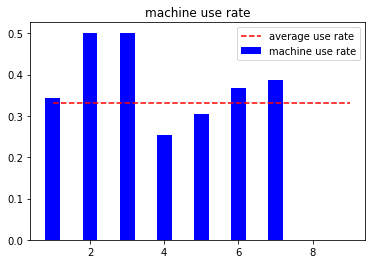

In [21]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(machine_nm)]

y = use_rate[-1]

plt.bar(x, y, width=0.4, color='b', label='machine use rate')

plt.title('machine use rate')

## 绘制一条平均使用率的参考线
plt.plot([1, machine_nm+1], [average_use_rate[-1], average_use_rate[-1]], color='r', linestyle='--', label='average use rate')

plt.legend()
plt.show()


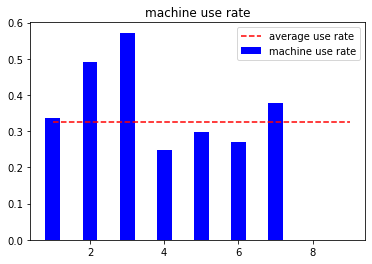

In [17]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(machine_nm)]

y = use_rate[-1]

plt.bar(x, y, width=0.4, color='b', label='machine use rate')

plt.title('machine use rate')

## 绘制一条平均使用率的参考线
plt.plot([1, machine_nm+1], [average_use_rate[-1], average_use_rate[-1]], color='r', linestyle='--', label='average use rate')

plt.legend()
plt.show()